In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily
import sklearn.cluster
import numpy as np

def make_geo(df_accidents: pd.DataFrame, df_locations: pd.DataFrame) -> geopandas.GeoDataFrame:
    """
    Create a GeoDataFrame from accident and location dataframes.

    :param df_accidents: DataFrame with accident data
    :param df_locations: DataFrame with location data
    """
    # Sort out only accidents in South Moravian Region
    df_accidents = df_accidents[df_accidents['p4a'] == 6]

    # Merge the two dataframes based on accident ID
    newDf = pd.merge(df_accidents, df_locations, on='p1')

    # Filter out rows with missing coordinates
    newDf = newDf[newDf['d'].notna() & newDf['e'].notna()]

    # Copy the dataframe to avoid SettingWithCopyWarning
    filteredDf = newDf.copy()

    # Swap columns if d is smaller than e (x < y)
    filteredDf[['d', 'e']] = filteredDf[['d', 'e']].where(filteredDf['d'] >= filteredDf['e'], filteredDf[['e', 'd']].values)

    # Create a GeoDataFrame from points in previous dataframe using Krovak projection
    geoDf = geopandas.GeoDataFrame(filteredDf, geometry=geopandas.points_from_xy(filteredDf.d, filteredDf.e), crs='EPSG:5514')

    return geoDf

In [148]:
def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None,
             show_figure: bool = False):
    """
    Plot two subgraphs of accidents under the influence of alcohol in South Moravian Region in January and July.

    :param gdf: GeoDataFrame for plotting created by make_geo function
    :param fig_location: Path to save the figure
    :param show_figure: If True, show the figure
    """
    # Copy original DataFrame to avoid SettingWithCopyWarning
    dfAlcoholOnly = gdf.copy()

    # Filter out only accidents where alcohol was involved
    dfAlcoholOnly = dfAlcoholOnly[dfAlcoholOnly["p11"] >= 4]

    # Create new column with a month of the accident
    dfAlcoholOnly["month"] = pd.to_datetime(dfAlcoholOnly["p2a"], format="%d.%m.%Y").dt.month

    # Reproject the data to GPS coordinates
    dfAlcoholOnly = dfAlcoholOnly.to_crs(epsg=4326)

    # Get the bounds of the data
    minX, minY, maxX, maxY = dfAlcoholOnly.total_bounds
    xRange = maxX - minX
    yRange = maxY - minY

    # Apply zoom
    minX = minX + xRange * 0.1
    maxX = maxX - xRange * 0.3
    # minY = minY + yRange * 0.1
    maxY = maxY - yRange * 0.17

    # Create a figure with two subgraphs
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    # Plot each month in specified subgraph
    dfAlcoholOnly[dfAlcoholOnly["month"] == 1].plot(ax=axes[0], color='red', markersize=10, label="Leden")
    dfAlcoholOnly[dfAlcoholOnly["month"] == 7].plot(ax=axes[1], color='red', markersize=10, label="Červenec")

    # Set parameters for each subgraph
    for i, ax in enumerate(axes):

        # Set the title and labels
        ax.set_title(f'JHM kraj pod vlivem alkoholu - ({"Leden" if i == 0 else "Červenec"})')
        ax.set_xlabel("Nadmořská šířka")
        ax.set_ylabel("Nadmořská výška")

        # Set the bounds of the plot
        ax.set_xlim(minX, maxX)
        ax.set_ylim(minY, maxY)

        # Set ticks on both axes to show degrees
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xticklabels([f'{xtick:.1f}°' for xtick in xticks])
        ax.set_yticklabels([f'{ytick:.1f}°' for ytick in yticks])

        # ax.set_aspect('equal')

        # Add basemap
        contextily.add_basemap(ax, crs=dfAlcoholOnly.crs.to_string(), alpha=0.9)

    # Tight layout to prevent overlapping
    fig.tight_layout()

    # If path is specified, save the figure
    if fig_location:
        plt.savefig(fig_location, bbox_inches='tight')

    # If True, show the figure
    if show_figure:
        plt.show()


In [156]:
def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    """
    Plot accidents caused by wild animals in clusters.

    :param gdf: GeoDataFrame for plotting created by make_geo function
    :param fig_location: Path to save the figure
    :param show_figure: If True, show the figure
    """
    # Copy original DataFrame to avoid SettingWithCopyWarning
    newDf = gdf.copy()

    # Filter out only accidents caused by wild animals
    newDf = newDf[newDf["p10"] == 4]

    # Reproject the data to Web Mercator
    newDf = newDf.to_crs(epsg=3857)

    # Create a coordinate matrix
    coordinates = np.dstack([newDf.geometry.x, newDf.geometry.y]).reshape(-1, 2)

    """
    The method chosen for clustering is KMeans in MiniBatchKMeans variant (faster than classic KMeans). It was presented on lectures
    and when tried on the dataset, I found a solution correspondning with reference solution. The number of clusters was set to 8.
    """

    # Apply KMeans clustering for the coordinates
    db = sklearn.cluster.MiniBatchKMeans(n_clusters=8).fit(coordinates)

    # Create new column with labels for each cluster
    newDf['cluster'] = db.labels_

    # Use dissolve to merge the clusters, count number of accidents in each cluster and save it to new column
    accidentClusters = newDf.dissolve(by='cluster', aggfunc={"p1": "count"}).rename(columns={"p1": "cnt"})

    # Add geometry column with convex hull for each cluster
    accidentClusters['geometry'] = accidentClusters.geometry.convex_hull

    # Create a figure
    plt.figure(figsize=(15, 12))
    ax = plt.gca()

    # Set the title
    ax.set_title("Nehody v JHM kraji zaviněné lesní zvěří")

    # Plot each accident as a point
    newDf.plot(ax=ax, color='tab:red', alpha=0.35)

    # Plot each cluster as a polygon with color corresponding to the number of accidents in the cluster
    accidentClusters.plot(ax=ax, column='cnt', legend=True, cmap='viridis', alpha=0.5, legend_kwds={'label': "Počet nehod v úseku", 'orientation': "horizontal", 'shrink': 0.91, 'pad': 0.01})

    # Add the background map
    contextily.add_basemap(ax, crs=newDf.crs.to_string(), alpha=0.9, zoom=9)

    # Remove x and y axis with labels
    ax.axis('off')

    # Limit the x and y axes to remove accidents outside the region (2 of them)
    ax.set_xlim(right=(1.98e6))
    ax.set_ylim(top=(6.39e6))

    # Tight layout to prevent overlapping
    plt.tight_layout()

    # If path is specified, save the figure
    if fig_location:
        plt.savefig(fig_location, bbox_inches='tight')

    # If True, show the figure
    if show_figure:
        plt.show()

    pass

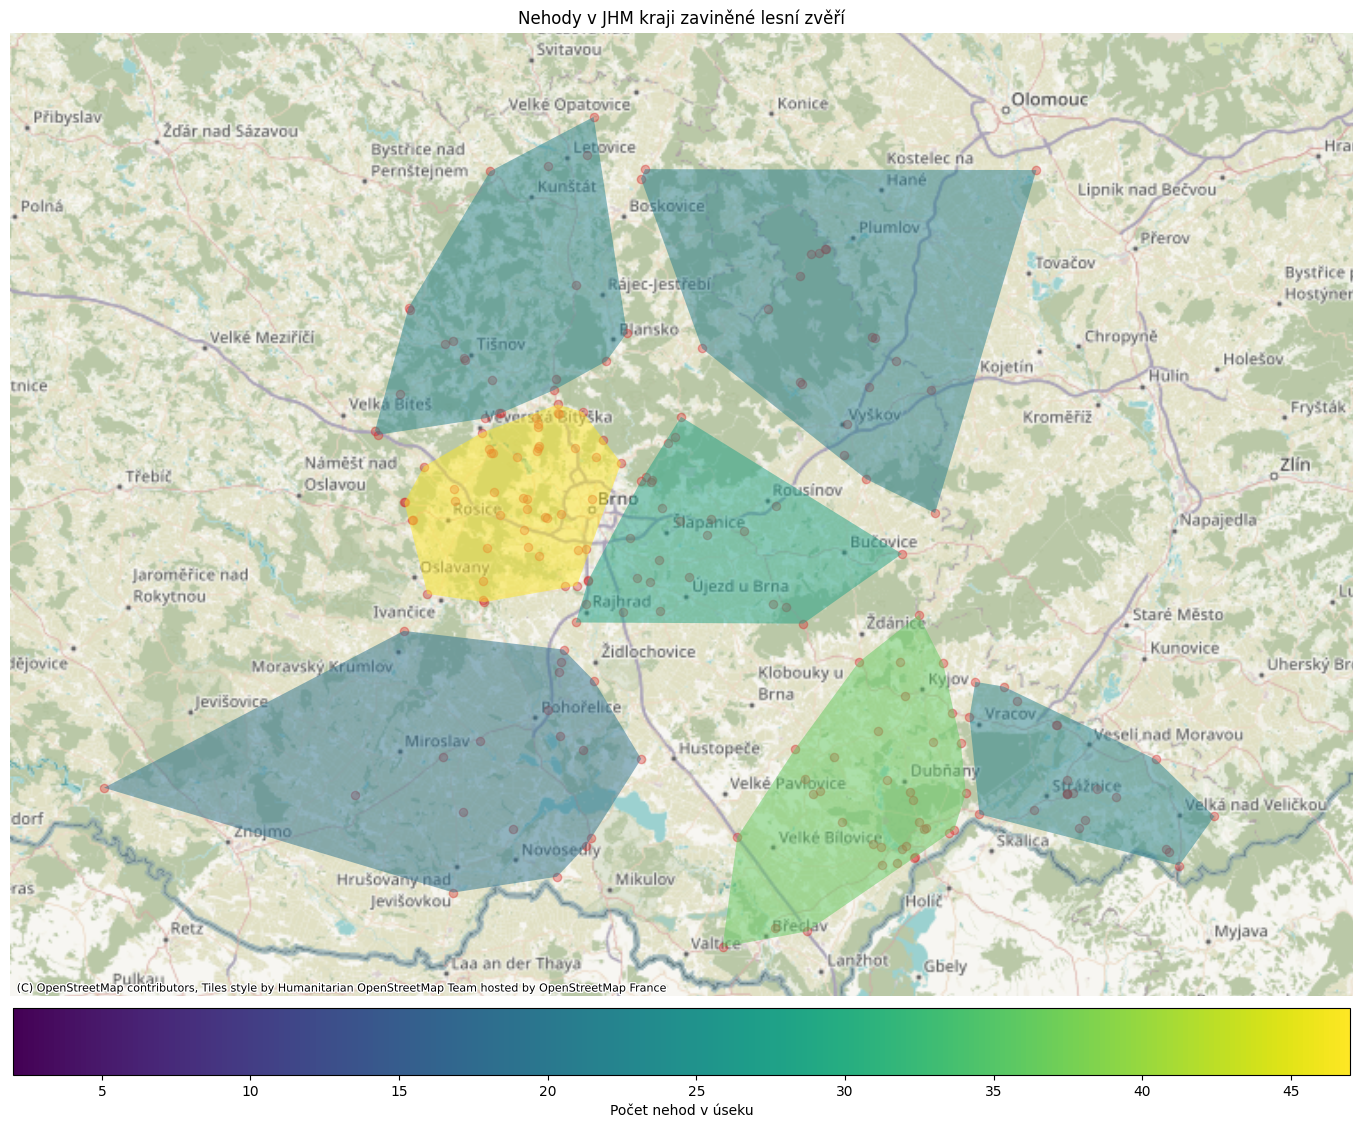

In [157]:
df_accidents = pd.read_pickle("accidents.pkl.gz")
df_locations = pd.read_pickle("locations.pkl.gz")
gdf = make_geo(df_accidents, df_locations)
# plot_geo(gdf, "geo1.png", True)
plot_cluster(gdf, "geo2.png", True)